# 250-D Multivariate Normal

Let's go for broke here.

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# seed the random number generator
np.random.seed(2018)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

Here we will quickly demonstrate that slice sampling is able to cope with very high-dimensional problems without the use of gradients. Our target will in this case be a 250-D uncorrelated multivariate normal distribution with an identical prior.

In [4]:
from scipy.special import ndtri

ndim = 250  # number of dimensions
C = np.identity(ndim)  # set covariance to identity matrix
Cinv = linalg.inv(C)  # precision matrix
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))  # ln(normalization)

# 250-D iid standard normal log-likelihood
def loglikelihood(x):
    """Multivariate normal log-likelihood."""
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# prior transform (iid standard normal prior)
def prior_transform(u):
    """Transforms our unit cube samples `u` to a flat prior between -10. and 10. in each variable."""
    return ndtri(u)

# ln(evidence)
lnz_truth = lnorm - 0.5 * ndim * np.log(2)
print(lnz_truth)

-316.378030871


We will use Hamiltonian Slice Sampling (`'hslice'`) to sample in high dimensions. We will also utilize a small number of overall particles ($K < N$) to demonstrate that we can be quite sparsely sampled in this regime and still perform decently well.

In [5]:
# hamiltonian slice sampling ('hslice')
sampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim,
                                       bound='none', sample='hslice', slices=10)
sampler.run_nested(nlive_init=100, nlive_batch=100)
res = sampler.results

/home/joshspeagle/anaconda/lib/python2.7/site-packages/dynesty-0.9.2-py2.7.egg/dynesty/dynamicsampler.py:712: UserWarning: Beware: `nlive_init <= 2 * ndim`!
iter: 4588 | batch: 0 | bound: 0 | nc: 1 | ncall: 2204646 | eff(%):  0.208 | loglstar:   -inf < -276.062 <    inf | logz: -316.115 +/-  0.491 | dlogz:  0.000 >  0.010              /home/joshspeagle/anaconda/lib/python2.7/site-packages/dynesty-0.9.2-py2.7.egg/dynesty/dynamicsampler.py:964: UserWarning: Beware: `nlive_batch <= 2 * ndim`!
iter: 27064 | batch: 15 | bound: 26 | nc: 527 | ncall: 14018037 | eff(%):  0.193 | loglstar: -299.596 < -271.173 < -273.405 | logz: -316.034 +/-  0.274 | stop:  0.916            


Let's dump our results to disk to avoid losing all that work!

In [6]:
import pickle

# dump results
output = open('250d_gauss.pkl', 'wb')
pickle.dump(sampler.results, output)
output.close()

In [7]:
import pickle
output = open('250d_gauss.pkl', 'rb')
res = pickle.load(output)
output.close()

Now let's see how our sampling went.

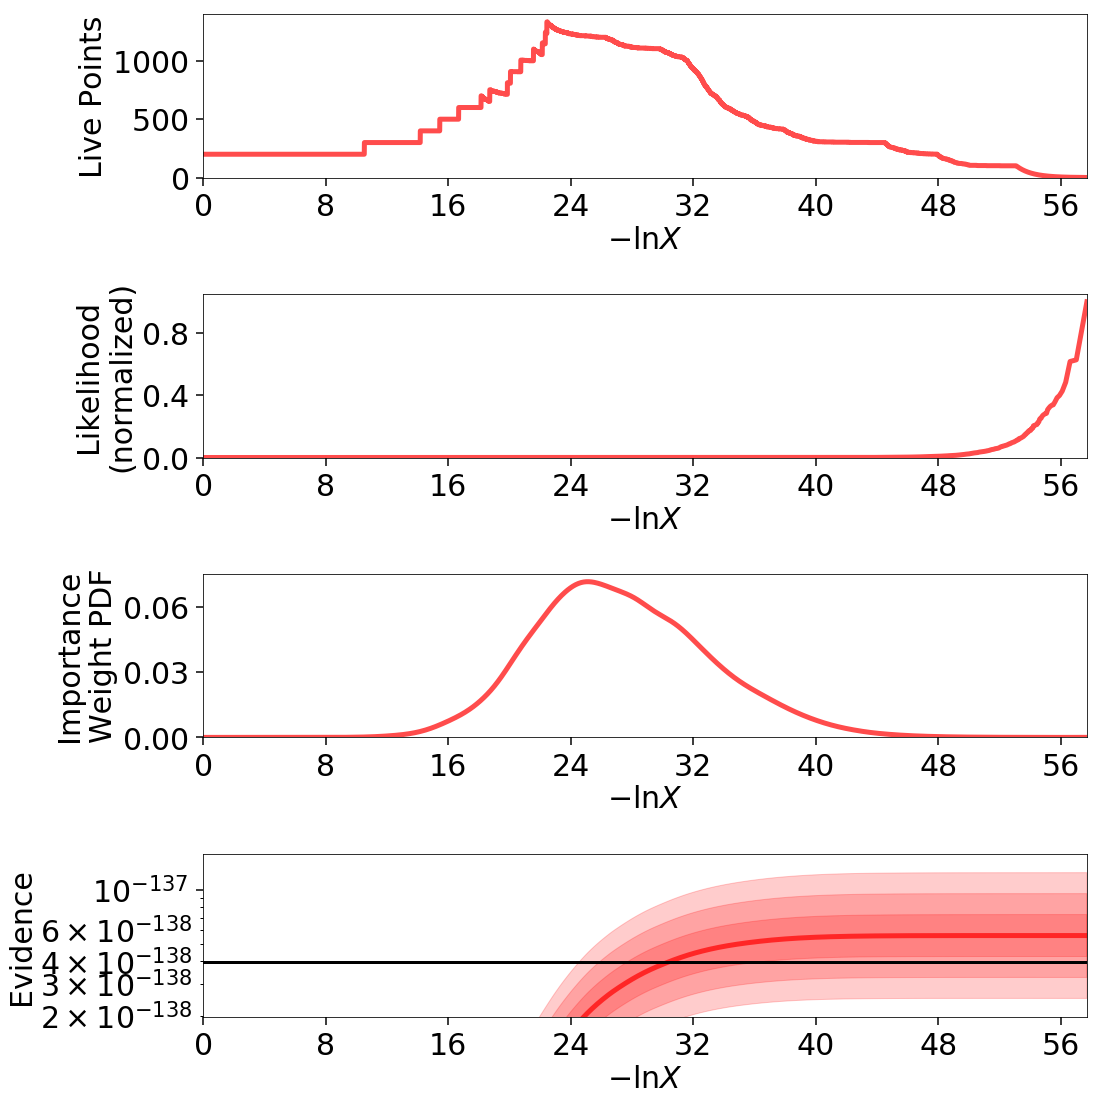

In [8]:
from dynesty import plotting as dyplot

# evidence check
fig, axes = dyplot.runplot(res, color='red', lnz_truth=lnz_truth, truth_color='black', logplot=True)
fig.tight_layout()

0.707106781187


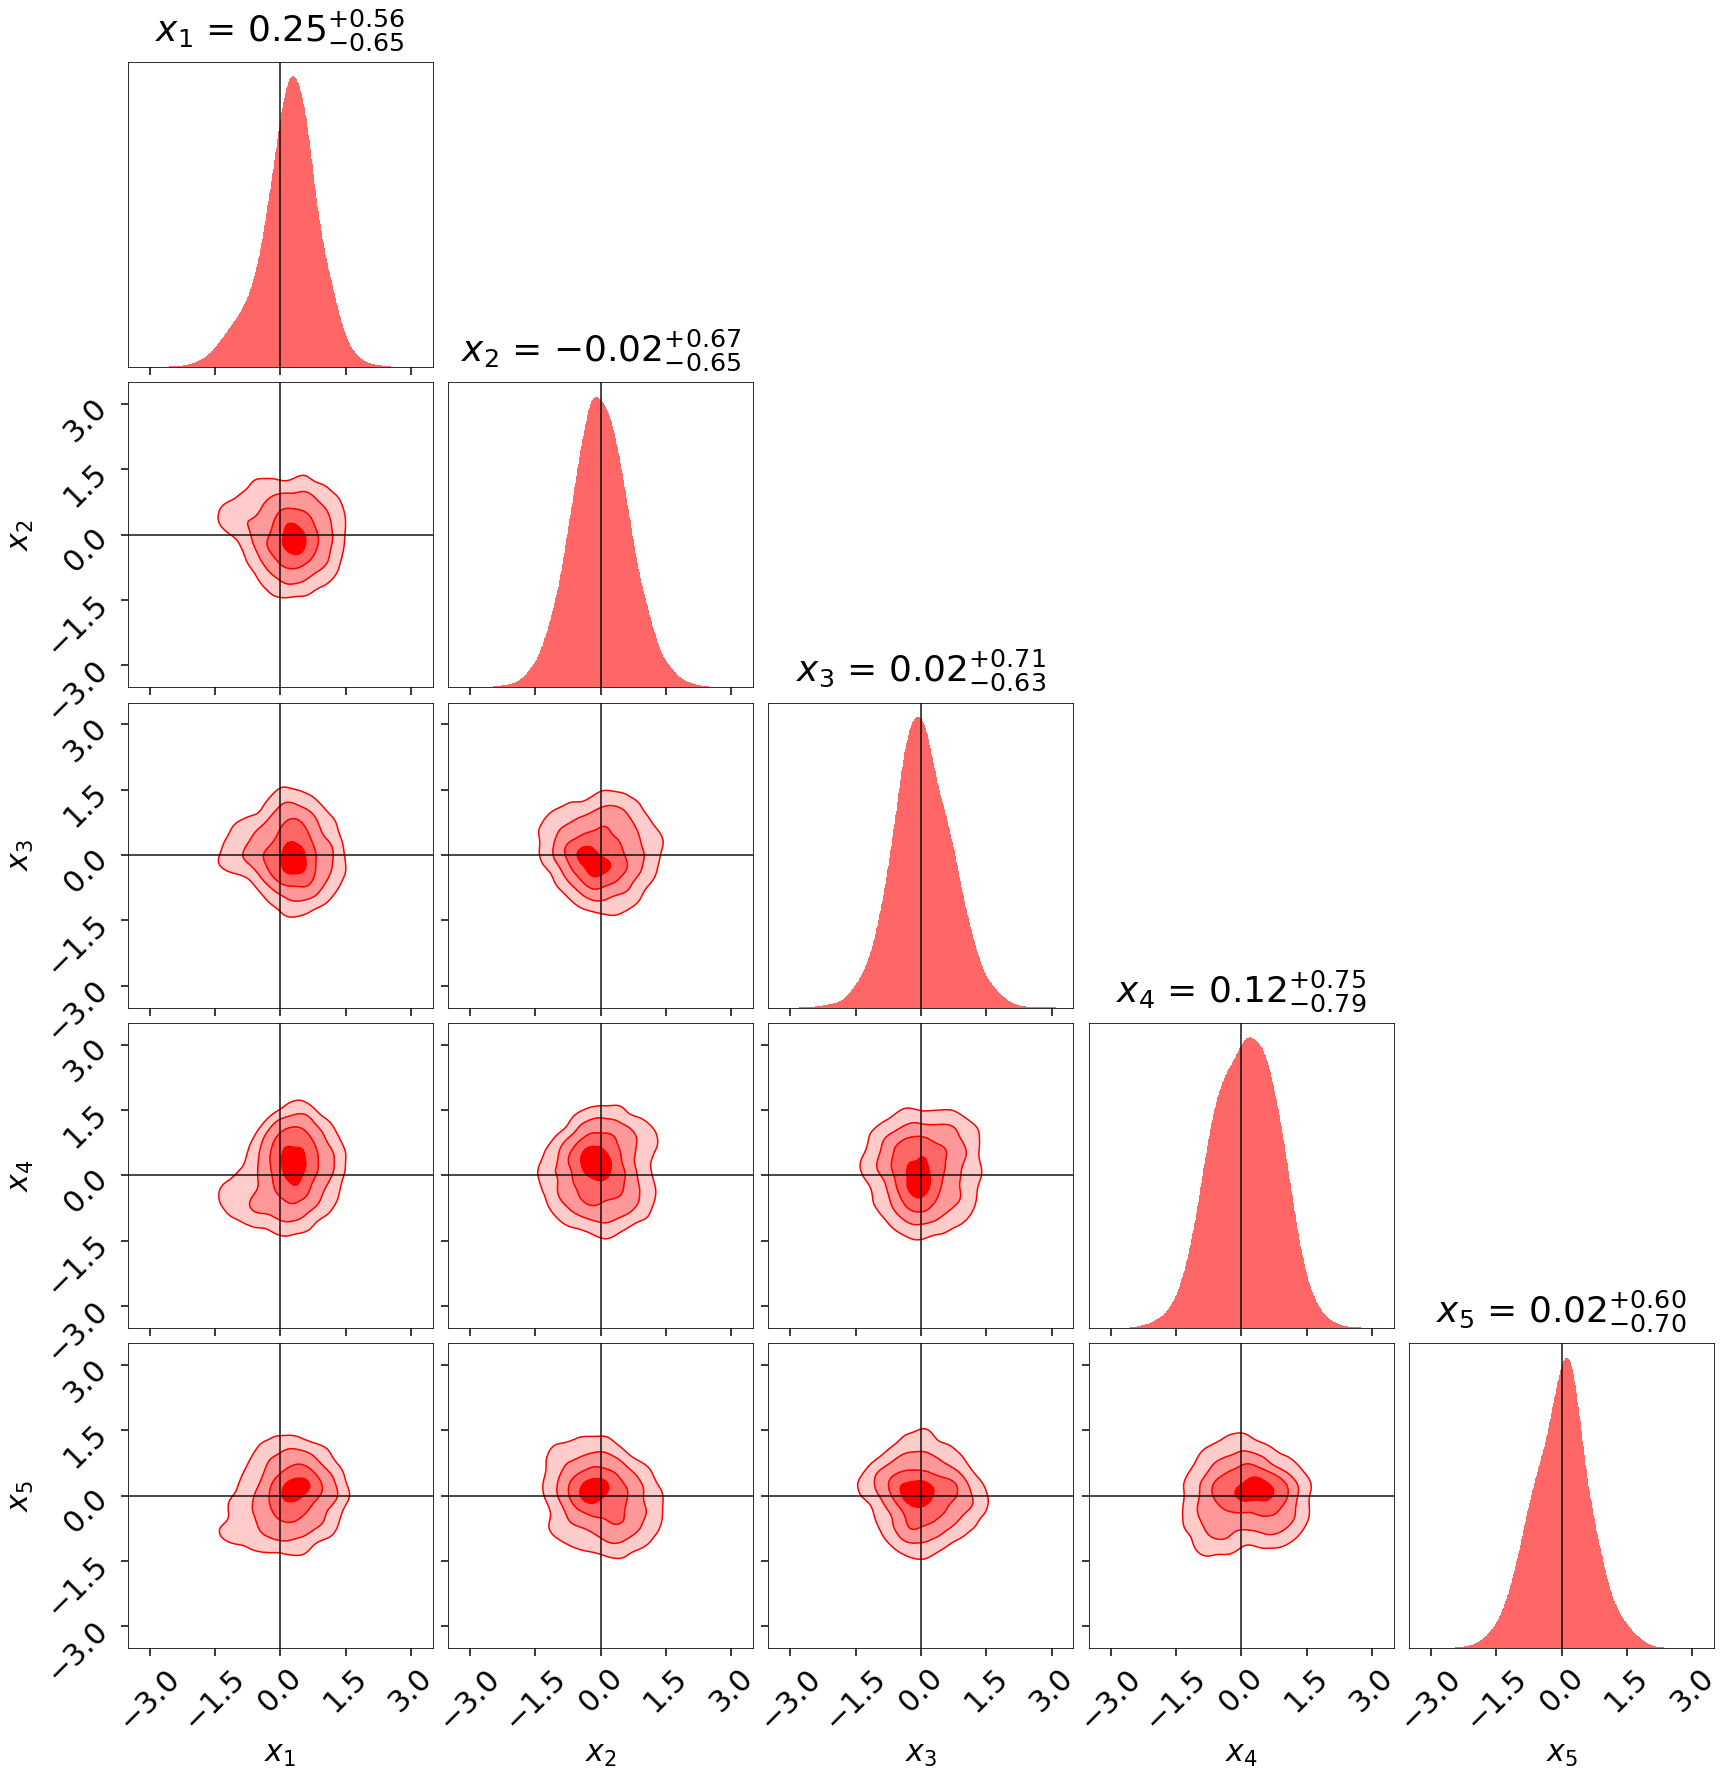

In [9]:
# posterior check
dims = [-1, -2, -3, -4, -5]
fig, ax = plt.subplots(5, 5, figsize=(25, 25))
samps, samps_t = res.samples, res.samples[:,dims]
res.samples = samps_t
fg, ax = dyplot.cornerplot(res, color='red', truths=np.zeros(ndim), truth_color='black',
                           span=[(-3.5, 3.5) for i in range(len(dims))],
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, fig=(fig, ax))
res.samples = samps
print(1./np.sqrt(2))

That looks good! Obviously we can't plot the full 250x250 plot, but 5x5 subplots should do.

Now we can finally check how well our mean and covariances agree.

In [10]:
# let's confirm we actually got the entire distribution
from dynesty import utils

weights = np.exp(res.logwt - res.logz[-1])
mu, cov = utils.mean_and_cov(samps, weights)

Means (0.): 0.00636376526791 +/- 0.155840359348
Variance (0.5): 0.472070531386 +/- 0.0588726231345
Covariance (0.): 0.000327029115282 +/- 0.062871902272


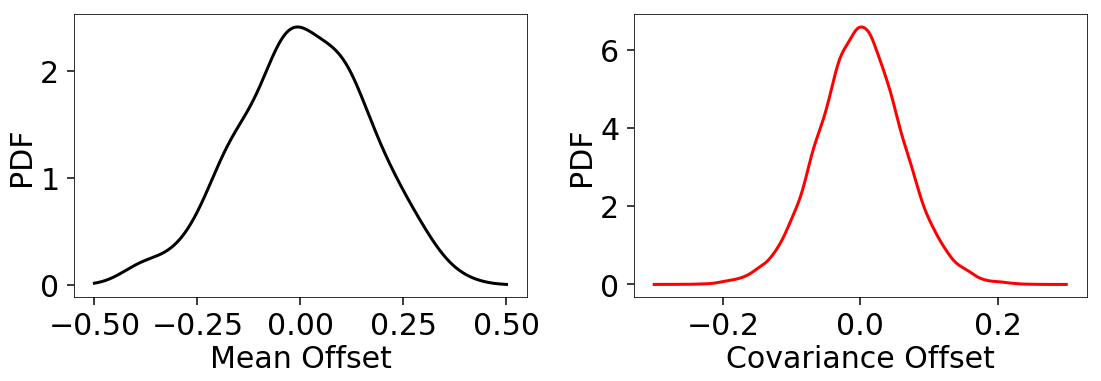

In [11]:
# plot residuals
from scipy.stats.kde import gaussian_kde
mu_kde = gaussian_kde(mu)
xgrid = np.linspace(-0.5, 0.5, 1000)
mu_pdf = mu_kde.pdf(xgrid)
cov_kde = gaussian_kde((cov - C).flatten())
xgrid2 = np.linspace(-0.3, 0.3, 1000)
cov_pdf = cov_kde.pdf(xgrid2)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(xgrid, mu_pdf, lw=3, color='black')
plt.xlabel('Mean Offset')
plt.ylabel('PDF')
plt.subplot(1, 2, 2)
plt.plot(xgrid2, cov_pdf, lw=3, color='red')
plt.xlabel('Covariance Offset')
plt.ylabel('PDF')

# print values
print('Means (0.):', np.mean(mu), '+/-', np.std(mu))
print('Variance (0.5):', np.mean(np.diag(cov)), '+/-', np.std(np.diag(cov)))
cov_up = np.triu(cov, k=1).flatten()
cov_low = np.tril(cov,k=-1).flatten()
cov_offdiag = np.append(cov_up[abs(cov_up) != 0.], cov_low[cov_low != 0.])
print('Covariance (0.):', np.mean(cov_offdiag), '+/-', np.std(cov_offdiag))
plt.tight_layout()

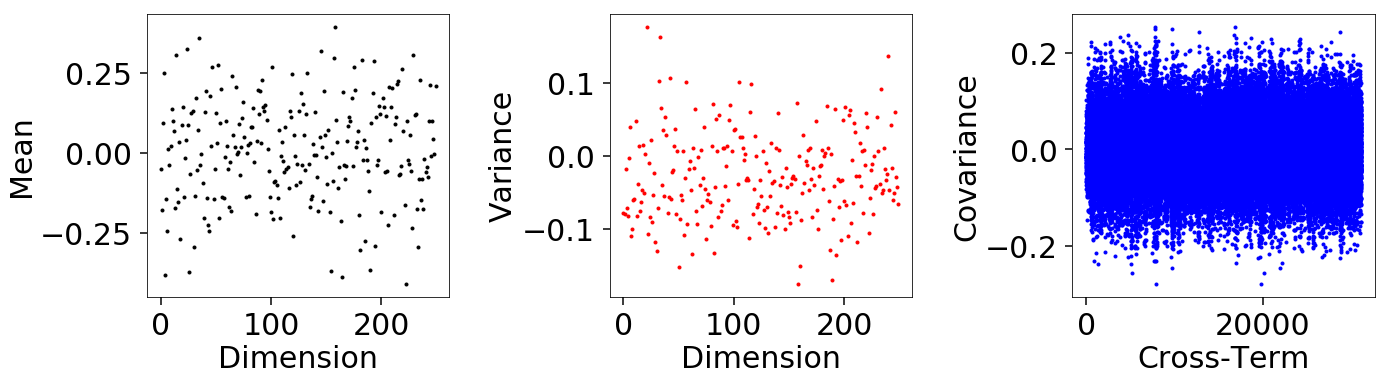

In [12]:
# plot individual values
plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)
plt.plot(mu, 'k.')
plt.ylabel('Mean')
plt.xlabel('Dimension')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.plot(np.diag(cov) - 0.5, 'r.')
plt.ylabel('Variance')
plt.xlabel('Dimension')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.plot(cov_low[cov_low != 0.], 'b.')
plt.plot(cov_up[cov_up != 0.], 'b.')
plt.ylabel('Covariance')
plt.xlabel('Cross-Term')
plt.tight_layout()